# Predicting the demand of consumable retail products

In [5]:
#importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import random 
import xgboost as xgb
#!pip install lightgbm
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/' 
train = pd.read_csv(path+'Copy of train (1).csv',header=0)
train.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


,experiment_week,channel_type,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,store_identifier,product_identifier,category_of_route,supplier_identifier
0,Week 1 of 2019,Warehouse Retailers,3,377.1,0,0.0,store_fc6aa,product_cbfad,route_67047,supplier_identifier_055f7
1,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_2b363,route_67047,supplier_identifier_055f7
2,Week 1 of 2019,Warehouse Retailers,4,589.8,0,0.0,store_fc6aa,product_8de14,route_67047,supplier_identifier_055f7
3,Week 1 of 2019,Warehouse Retailers,4,502.8,0,0.0,store_fc6aa,product_1c00e,route_67047,supplier_identifier_055f7
4,Week 1 of 2019,Warehouse Retailers,3,343.8,0,0.0,store_fc6aa,product_55001,route_67047,supplier_identifier_055f7


In [0]:
train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53364883 entries, 0 to 53364882
Data columns (total 10 columns):
experiment_week                object
channel_type                   object
num_units_sold_in_week         int64
sales_revenue_in_week          float64
num_units_returned             int64
returned_units_revenue_loss    float64
store_identifier               object
product_identifier             object
category_of_route              object
supplier_identifier            object
dtypes: float64(2), int64(2), object(6)
memory usage: 23.0 GB


In [0]:
train.memory_usage(deep=True)

Index                                  80
experiment_week                3788906693
channel_type                   3792755532
num_units_sold_in_week          426919064
sales_revenue_in_week           426919064
num_units_returned              426919064
returned_units_revenue_loss     426919064
store_identifier               3628812044
product_identifier             3735541810
category_of_route              3628812044
supplier_identifier            4375920406
dtype: int64

In [0]:
#To make this easier to read, we convert all values to megabytes
train.memory_usage(deep=True) * 1e-6

Index                             0.000080
experiment_week                3788.906693
channel_type                   3792.755532
num_units_sold_in_week          426.919064
sales_revenue_in_week           426.919064
num_units_returned              426.919064
returned_units_revenue_loss     426.919064
store_identifier               3628.812044
product_identifier             3735.541810
category_of_route              3628.812044
supplier_identifier            4375.920406
dtype: float64

In [0]:
#The total memory usage can be seen like this:
train.memory_usage(deep=True).sum() * 1e-6

24658.424864999997

In [3]:
test = pd.read_csv('C:/Users/Lenovo/Desktop/phd original work/Modeling/test.csv',header=0)
test.head()

,id,experiment_week,channel_type,supplier_identifier,category_of_route,store_identifier,product_identifier
0,1,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_cbfad
1,2,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_2b363
2,3,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_f79b8
3,4,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_8de14
4,5,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_1c00e


In [0]:
test.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20815581 entries, 0 to 20815580
Data columns (total 7 columns):
id                     int64
experiment_week        object
channel_type           object
supplier_identifier    object
category_of_route      object
store_identifier       object
product_identifier     object
dtypes: int64(1), object(6)
memory usage: 8.5 GB


In [0]:
test.memory_usage(deep=True)

Index                          80
id                      166524648
experiment_week        1477906251
channel_type           1479526146
supplier_identifier    1706877642
category_of_route      1415459508
store_identifier       1415459508
product_identifier     1457090670
dtype: int64

In [0]:
#To make this easier to read, we convert all values to megabytes
test.memory_usage(deep=True) * 1e-6

Index                     0.000080
id                      166.524648
experiment_week        1477.906251
channel_type           1479.526146
supplier_identifier    1706.877642
category_of_route      1415.459508
store_identifier       1415.459508
product_identifier     1457.090670
dtype: float64

In [0]:
#The total memory usage can be seen like this:
test.memory_usage(deep=True).sum() * 1e-6

9118.844453

In [0]:
train.shape

(53364883, 10)

In [0]:
test.shape

(20815581, 7)

# Creating a target variable

In [0]:
train['demand_projection'] = train['num_units_sold_in_week']-train['num_units_returned']

In [0]:
#df["a"] = pd.to_numeric(df["a"])
train["demand_projection"] = pd.to_numeric(train["demand_projection"])

In [6]:
train["demand_projection"].dtypes

dtype('int64')

# Analyzing the Target Variable (demand_projection)

In [0]:
# Getting Description
train['demand_projection'].describe()

count    5.336488e+07
mean     7.180995e+00
std      2.207857e+01
min     -1.634500e+04
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      5.000000e+03
Name: demand_projection, dtype: float64

In [0]:
train['demand_projection'].dtypes

dtype('int64')


 mu = 7.18 and sigma = 22.08



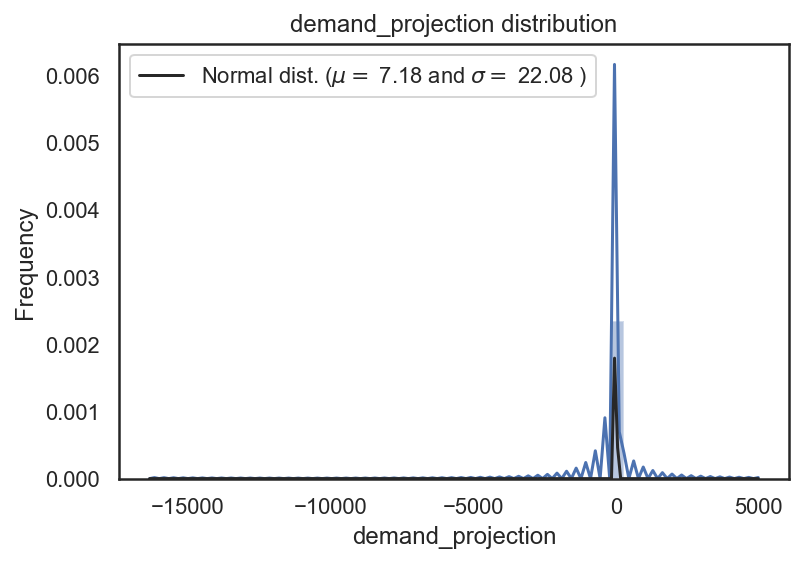

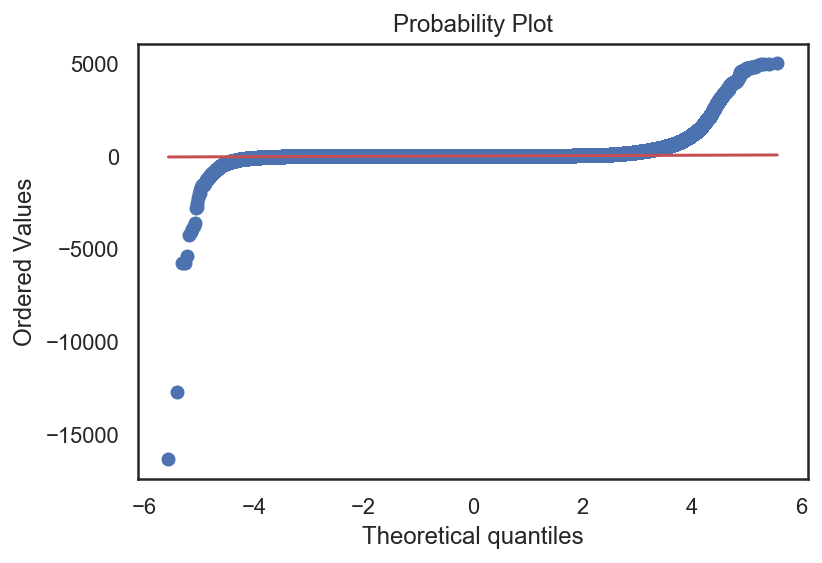

Skewness: 28.225174
Kurtosis: 12694.346942


In [0]:
#Plot Histogram
sns.distplot(train['demand_projection'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['demand_projection'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('demand_projection distribution')

fig = plt.figure()
res = stats.probplot(train['demand_projection'], plot=plt)
plt.show()

print("Skewness: %f" % train['demand_projection'].skew())
print("Kurtosis: %f" % train['demand_projection'].kurt())

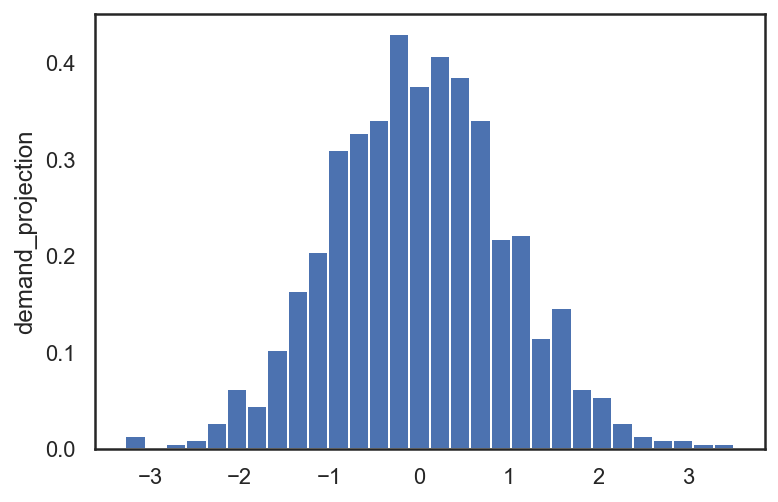

In [0]:
%matplotlib inline
x = np.random.normal(size = 1000)
plt.hist(x, density=True, bins=30) # density
plt.ylabel('demand_projection');

# EDA

In [7]:
#Droping columns since train and test should contain same number of columns for the prediction process.
columnDrop = ['num_units_sold_in_week','sales_revenue_in_week', 'num_units_returned','returned_units_revenue_loss']
for a in columnDrop:
  train.drop(a, axis = 1, inplace=True)
train.dtypes

experiment_week        object
channel_type           object
store_identifier       object
product_identifier     object
category_of_route      object
supplier_identifier    object
demand_projection       int64
dtype: object

In [8]:
# Check data size after dropping the columns
print("\nThe train data size after dropping columns is : {} ".format(train.shape)) 
print("The test data size after dropping columns is : {} ".format(test.shape))


The train data size after dropping columns is : (53364883, 7) 
The test data size after dropping columns is : (20815581, 7) 


In [9]:
train.head()

,experiment_week,channel_type,store_identifier,product_identifier,category_of_route,supplier_identifier,demand_projection
0,Week 1 of 2019,Warehouse Retailers,store_fc6aa,product_cbfad,route_67047,supplier_identifier_055f7,3
1,Week 1 of 2019,Warehouse Retailers,store_fc6aa,product_2b363,route_67047,supplier_identifier_055f7,4
2,Week 1 of 2019,Warehouse Retailers,store_fc6aa,product_8de14,route_67047,supplier_identifier_055f7,4
3,Week 1 of 2019,Warehouse Retailers,store_fc6aa,product_1c00e,route_67047,supplier_identifier_055f7,4
4,Week 1 of 2019,Warehouse Retailers,store_fc6aa,product_55001,route_67047,supplier_identifier_055f7,3


In [10]:
test.head()

,id,experiment_week,channel_type,supplier_identifier,category_of_route,store_identifier,product_identifier
0,1,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_cbfad
1,2,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_2b363
2,3,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_f79b8
3,4,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_8de14
4,5,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_1c00e


### Multivariable Analysis

In [55]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['experiment_week', 'channel_type', 'store_identifier',
       'product_identifier', 'category_of_route', 'supplier_identifier'],
      dtype='object')

In [56]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['demand_projection'], dtype='object')

In [57]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  6 categorical + 1 numerical = 7 features


In [14]:
# Checking Categorical Data
test.select_dtypes(include=['object']).columns

Index(['experiment_week', 'channel_type', 'supplier_identifier',
       'category_of_route', 'store_identifier', 'product_identifier'],
      dtype='object')

In [15]:
# Checking Numerical Data
test.select_dtypes(include=['int64','float64']).columns

Index(['id'], dtype='object')

In [16]:
cat = len(test.select_dtypes(include=['object']).columns)
num = len(test.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  6 categorical + 1 numerical = 7 features


### Feature Engineering

In [17]:
# finding count of missing values
train.apply(lambda x: sum(x.isnull()))

experiment_week        0
channel_type           0
store_identifier       0
product_identifier     0
category_of_route      0
supplier_identifier    0
demand_projection      0
dtype: int64

In [18]:
#finding unique values in each column
train.apply(lambda x: len(x.unique()))

experiment_week             5
channel_type                9
store_identifier       587773
product_identifier       1736
category_of_route        3490
supplier_identifier       552
demand_projection        2332
dtype: int64

In [19]:
#For example few of them are:-
train['experiment_week'].unique()

array(['Week 1 of 2019', 'Week 2 of 2019', 'Week 3 of 2019',
       'Week 4 of 2019', 'Week 5 of 2019'], dtype=object)

In [20]:
train['channel_type'].unique()

array(['Warehouse Retailers', 'Discount Retailer', 'Department Stores',
       'Grocery Stores', 'Supermarkets', 'Specialty Retailers',
       'Wholesale Retailers', 'Convenience Retailer',
       'Internet Retailers'], dtype=object)

In [0]:
#Converting into a categorical variable
train['experiment_week'] = train['experiment_week'].astype(str)
train['channel_type'] = train['channel_type'].astype(str)
train['store_identifier'] = train['store_identifier'].astype(str)
train['product_identifier'] = train['product_identifier'].astype(str)
train['category_of_route'] = train['category_of_route'].astype(str)
train['supplier_identifier'] = train['supplier_identifier'].astype(str)

In [22]:
# using label encoder method to give numeric values to categorical columns
from sklearn.preprocessing import LabelEncoder
cols = ('experiment_week', 'channel_type', 'store_identifier',
       'product_identifier', 'category_of_route', 'supplier_identifier')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))

# Check shape        
print('Shape train: {}'.format(train.shape))

Shape train: (53364883, 7)


In [23]:
train.dtypes

experiment_week        int64
channel_type           int64
store_identifier       int64
product_identifier     int64
category_of_route      int64
supplier_identifier    int64
demand_projection      int64
dtype: object

In [24]:
# finding count of missing values
test.apply(lambda x: sum(x.isnull()))

id                     0
experiment_week        0
channel_type           0
supplier_identifier    0
category_of_route      0
store_identifier       0
product_identifier     0
dtype: int64

In [25]:
#finding unique values in each column
test.apply(lambda x: len(x.unique()))

id                     20815581
experiment_week               2
channel_type                  9
supplier_identifier         552
category_of_route          3003
store_identifier         564554
product_identifier         1633
dtype: int64

In [26]:
#For example few of them are:-
test['experiment_week'].unique()

array(['Week 6 of 2019', 'Week 7 of 2019'], dtype=object)

In [27]:
test['channel_type'].unique()

array(['Warehouse Retailers', 'Discount Retailer', 'Department Stores',
       'Grocery Stores', 'Supermarkets', 'Specialty Retailers',
       'Wholesale Retailers', 'Convenience Retailer',
       'Internet Retailers'], dtype=object)

In [0]:
#Converting into a categorical variable
test['experiment_week'] = test['experiment_week'].astype(str)
test['channel_type'] = test['channel_type'].astype(str)
test['store_identifier'] = test['store_identifier'].astype(str)
test['product_identifier'] = test['product_identifier'].astype(str)
test['category_of_route'] = test['category_of_route'].astype(str)
test['supplier_identifier'] = test['supplier_identifier'].astype(str)

In [29]:
# using label encoder method to give numeric values to categorical columns
from sklearn.preprocessing import LabelEncoder
cols = ('experiment_week', 'channel_type', 'store_identifier',
       'product_identifier', 'category_of_route', 'supplier_identifier')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(test[c].values)) 
    test[c] = lbl.transform(list(test[c].values))

# Check shape        
print('Shape test: {}'.format(test.shape))

Shape test: (20815581, 7)


In [30]:
test.dtypes

id                     int64
experiment_week        int64
channel_type           int64
supplier_identifier    int64
category_of_route      int64
store_identifier       int64
product_identifier     int64
dtype: object

In [31]:
train.head()

,experiment_week,channel_type,store_identifier,product_identifier,category_of_route,supplier_identifier,demand_projection
0,0,7,579653,1381,1365,12,3
1,0,7,579653,272,1365,12,4
2,0,7,579653,992,1365,12,4
3,0,7,579653,174,1365,12,4
4,0,7,579653,590,1365,12,3


In [32]:
test.head()

,id,experiment_week,channel_type,supplier_identifier,category_of_route,store_identifier,product_identifier
0,1,0,7,12,1178,556783,1302
1,2,0,7,12,1178,556783,261
2,3,0,7,12,1178,556783,1580
3,4,0,7,12,1178,556783,940
4,5,0,7,12,1178,556783,163


In [33]:
train.shape

(53364883, 7)

In [34]:
test.shape

(20815581, 7)

In [0]:
# Save the 'Id' column
test_ID = test['id']

In [0]:
# Now drop the 'Id' column since it's unnecessary for the prediction process.
test.drop("id", axis = 1, inplace = True)

In [37]:
test_ID.head()

0    1
1    2
2    3
3    4
4    5
Name: id, dtype: int64

# Modeling and Predictions

In [6]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
import xgboost as xgb
import lightgbm as lgb

In [36]:
#Define target and ID columns:
target = 'demand_projection'
IDcol = "id"
from sklearn import metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Remember the target had been normalized
    #Sq_train = (dtrain[target])**2
    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors],dtrain[target] , cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    #submission.to_csv(filename, index=False)

    sub = pd.DataFrame()
    sub['id'] = test_ID
    sub['demand_projection'] = dtest[target]
    sub.to_csv(filename, index=False)


# Linear Regression Model

In [37]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression(normalize=True)
predictors = train.columns.drop(['demand_projection'])
modelfit(LR, train, test, predictors, target, IDcol, 'D:/PHD Submission folders/LR.csv')


Model Report
RMSE : 21.68
CV Score : Mean - 20.29 | Std - 7.665 | Min - 12.11 | Max - 40.83


In [38]:
test.head()

,experiment_week,channel_type,supplier_identifier,category_of_route,store_identifier,product_identifier,demand_projection
0,0,7,12,1178,556783,1302,-3.783393
1,0,7,12,1178,556783,261,-5.892036
2,0,7,12,1178,556783,1580,-3.220277
3,0,7,12,1178,556783,940,-4.516658
4,0,7,12,1178,556783,163,-6.090544


# Ridge Regression Model

In [39]:
from sklearn.linear_model import Ridge
RR = Ridge(alpha=0.05,normalize=True)
modelfit(RR, train, test, predictors, target, IDcol, 'D:/PHD Submission folders/RR.csv')


Model Report
RMSE : 21.68
CV Score : Mean - 20.29 | Std - 7.665 | Min - 12.11 | Max - 40.83


In [40]:
test.head()

,experiment_week,channel_type,supplier_identifier,category_of_route,store_identifier,product_identifier,demand_projection
0,0,7,12,1178,556783,1302,-3.230866
1,0,7,12,1178,556783,261,-5.237719
2,0,7,12,1178,556783,1580,-2.694934
3,0,7,12,1178,556783,940,-3.928734
4,0,7,12,1178,556783,163,-5.426645


# Decision Tree Model

In [41]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(DT, train, test, predictors, target, IDcol, 'D:/PHD Submission folders/DT.csv')


Model Report
RMSE : 19.39
CV Score : Mean - 18.14 | Std - 7.724 | Min - 10.21 | Max - 39.37


In [42]:
test.head()

,experiment_week,channel_type,supplier_identifier,category_of_route,store_identifier,product_identifier,demand_projection
0,0,7,12,1178,556783,1302,9.137255
1,0,7,12,1178,556783,261,15.729167
2,0,7,12,1178,556783,1580,9.137255
3,0,7,12,1178,556783,940,9.137255
4,0,7,12,1178,556783,163,15.729167


# Random Forrest Model

In [43]:
RF = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(RF, train, test, predictors, target, IDcol, 'D:/PHD Submission folders/RF.csv')


Model Report
RMSE : 19.71
CV Score : Mean - 18.37 | Std - 7.764 | Min - 10.44 | Max - 39.46


In [44]:
test.head()

,experiment_week,channel_type,supplier_identifier,category_of_route,store_identifier,product_identifier,demand_projection
0,0,7,12,1178,556783,1302,7.985185
1,0,7,12,1178,556783,261,11.346667
2,0,7,12,1178,556783,1580,7.985185
3,0,7,12,1178,556783,940,7.985185
4,0,7,12,1178,556783,163,11.346667


# XGBoost Model

In [45]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train[predictors], train[target], early_stopping_rounds=5, 
             eval_set=[(test[predictors], test[target])], verbose=False) 

[19:56:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [46]:
#Predict training set:
train_df_predictions = my_model.predict(train[predictors])
# make predictions
predictions = my_model.predict(test[predictors])
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test[target])))
print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error((train[target]).values, train_df_predictions)))
#IDcol.append(target)
   # submission = pd.DataFrame({ x: test_df[x] for x in IDcol})
   # submission.to_csv("merda.csv", index=False)            # xgboost continuation

Mean Absolute Error : 11.358518819721139
RMSE : 22.44


In [47]:
sub = pd.DataFrame()
sub['id'] = test_ID
sub['demand_projection'] = test[target]
sub.to_csv('D:/PHD Submission folders/XGboost.csv', index=False)

In [48]:
test.head()

,experiment_week,channel_type,supplier_identifier,category_of_route,store_identifier,product_identifier,demand_projection
0,0,7,12,1178,556783,1302,7.985185
1,0,7,12,1178,556783,261,11.346667
2,0,7,12,1178,556783,1580,7.985185
3,0,7,12,1178,556783,940,7.985185
4,0,7,12,1178,556783,163,11.346667
